# Feedback Alignment

##### Imports and helper functions

In [3]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [183]:
def get_loaders(batch_size, fashion=False):
    mnist = torchvision.datasets.MNIST
    if fashion:
        mnist = torchvision.datasets.FashionMNIST

    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),])

    trainloader = th.utils.data.DataLoader(
        mnist(root="./data", train=True, download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=2)
    testloader = th.utils.data.DataLoader(
        mnist(root="./data", train=False, download=True, transform=transform),
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)
    return trainloader, testloader

## Linear function approximation

<img href="images/linear.png">
We are considering a three-layer network of linear neurons, shown above. The network's output is $\boldsymbol{y}=W\boldsymbol{h}$, where $\boldsymbol{h}$ is the hidden-unit activity vector, given by $\boldsymbol{h}=W_0\boldsymbol{x}$, where $\boldsymbol{x}$ is the input to the network. $W_0$ is the matrix of synaptic weights from $\boldsymbol{x}$ to $\boldsymbol{h}$, and $W$ is the weights from $\boldsymbol{h}$ to $\boldsymbol{y}$. The network learns to approximate a linear function, $T$ (for 'target'). It's goal is to reduce the squared error, or loss, $\mathcal{L}=\frac{1}{2}\boldsymbol{e}^{T}\boldsymbol{e}$, where the error $\boldsymbol{e}=\boldsymbol{y^*}-\boldsymbol{y}=T\boldsymbol{x}-\boldsymbol{y}$. To train this network, the feedback alignment algorithm adjusts $W$ in the same way as backprop, i.e. $\Delta W\propto\frac{\partial\mathcal{L}}{\partial W}=-\boldsymbol{e}\boldsymbol{h}^T$, but for $W_0$, it uses a simpler formula, which needs no information about $W$ or any other synapses, but instead, sends $\boldsymbol{e}$ through a fixed random matrix $B$:
$$\Delta W_0\propto B\boldsymbol{e}\boldsymbol{x}^T$$

### Data Generation

The target linear function $T$ maps vectors from a $30$- to a $10$-dimensional space, i.e. $T$ has a shape of $10\times 30$. The elements of $T$ are drawn at random, that is, uniformly, from the range $[-1,1]$. Once chosen, the target matrix is fixed, so that each algorithm (i.e. feedback alignment and backpropagation) tried to learn the same function. Moreover, all algorithms are trained on the same sequence of input/output pairs, with $x\sim{}\mathcal{N}(\mu=0,\Sigma=I)$, $y^*=Tx$. We have chosen the **number of inputs** to be **100**.

##### linear function, inputs, and output generation

In [80]:
num_inputs = 10000

T = np.random.uniform(low=-1.0, high=1.0, size=(10, 30))
x_data = np.random.randn(30, num_inputs)
y_data = T @ x_data

`x_data`: `30 x num_inputs`

`y_data`: `10 x num_inputs`

##### Weights and biases random initalization

The elements of $B$ are drawn from the uniform distribution over $[-0.5, 0.5)$, while the elements of the network weight matrix, $W_0$ and $W$, are drawn unifromly from the range $[-0.01,0.01)$.

In [81]:
a = 0.01
W0 = np.random.uniform(-a, a, (20, 30))
b0 = np.random.uniform(-a, a, 20)

W = np.random.uniform(-a, a, (10, 20))
b = np.random.uniform(-a, a, 10)

a = 0.5
B = np.random.uniform(-a, a, (20, 10))

##### Training and Test dataset preparation

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x_data.T, y_data.T, test_size=0.25, shuffle=True)
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

In [83]:
x_test.shape

(30, 2500)

##### Hyperparameters

In [9]:
eta = 0.1
num_epochs = 1000
batch_size = 20
num_batches = x_train.shape[1] / batch_size

##### Creating batches

In [10]:
x_train_batches, y_train_batches = np.split(x_train, num_batches, axis=1), np.split(y_train, num_batches, axis=1)

In [11]:
for epoch in range(num_epochs):
    
    delta_W0, delta_W, loss = 0, 0, 0
    for i in range(len(x_train_batches)):
        training_data, training_labels = x_train_batches[i], y_train_batches[i]
        
        h = W0 @ training_data
        y = W @ h
        
        e = training_labels - y
        loss += 0.5 * np.square(np.linalg.norm(e))
        
        delta_BP = W.T @ e
        delta_FA = B @ e
        
        delta_W = delta_W + e @ h.T
        delta_W0 = delta_W0 + B @ e @ training_data.T
    
    W = W + (eta / (x_train.shape[1])) * delta_W
    W0 = W0 + (eta / (x_train.shape[1])) * delta_W0
    if epoch % 500 == 0:
        print(f"      Epoch {epoch}")
        print(f"      Current loss: {loss}")

      Epoch 0
      Current loss: 3972.613351303083
      Epoch 500
      Current loss: 1.5414066916807176e-06


In [12]:
h = W0 @ x_test
y = W @ h
e = y_test - y
test_error = 0.5 * np.square(np.linalg.norm(e))
test_error

6.168524287000316e-12

## Non-Linear function approximation

##### Hyperparameters

In [13]:
eta = 0.001
num_epochs = 5
batch_size = 20
num_batches = (60000) / batch_size

##### Weights and biases random initalization

In [14]:
a = 0.01
W0 = np.random.uniform(-a, a, (1000, 784))
b0 = np.random.uniform(-a, a, 1000)

W = np.random.uniform(-a, a, (10, 1000))
b = np.random.uniform(-a, a, 10)

a = 0.5
B = np.random.uniform(-a, a, (1000, 10))

In [15]:
u, s, vh = np.linalg.svd(W0)

##### Training and Test dataset preparation

In [41]:
trainloader, testloader = get_loaders(batch_size)

In [17]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

In [18]:
for epoch in range(num_epochs):
    delta_W0, delta_W, loss, size = 0, 0, 0, 0
    for training_data, training_labels in tqdm(trainloader, desc=f"      Epoch {epoch}"):
        training_data, training_labels = training_data.view(-1, 784).numpy(), training_labels.numpy()
        training_labels = np.reshape(training_labels, newshape=-1)
        training_labels = np.eye(10)[training_labels].T
        
        h = sigma(W0 @ training_data.T)
        h = h / np.linalg.norm(h)
        y = sigma(W @ h)
        e = training_labels - y
        loss += 0.5 * np.square(np.linalg.norm(e))
        
        delta_BP = W.T @ e
        delta_FA = B @ e
        
#         one_y, one_h = np.ones_like(y), np.ones_like(h)
        # y' = y * (1 - y)
        # h' = h * (1 - h)
        
        delta_W = delta_W + (e * (y * (1 - y))) @ h.T
        delta_W0 = delta_W0 + (delta_FA * h * (1 - h)) @ training_data
        
        size += training_data.shape[0]
    
    W = W + eta * delta_W
    W0 = W0 + eta * delta_W0
    if epoch % 10 == 0:
        print(f"      Epoch {epoch}")
        print(f"      Current loss: {loss}")

      Epoch 1:   0%|          | 0/3000 [00:00<?, ?it/s]

      Epoch 0
      Current loss: 74997.25899230651


      Epoch 4: 100%|██████████| 3000/3000 [00:23<00:00, 127.02it/s]


# Pytorch Implementation

In [300]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

## Random Data

In [193]:
num_inputs = 10000

T = np.random.uniform(low=-1.0, high=1.0, size=(10, 30))
x_data = np.random.randn(30, num_inputs)
y_data = T @ x_data

In [194]:
x_train, x_test, y_train, y_test = train_test_split(x_data.T, y_data.T, test_size=0.25, shuffle=True)
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

In [195]:
x_train, y_train = torch.from_numpy(x_train.T).float(), torch.from_numpy(y_train.T).float()
training_data = data_utils.TensorDataset(x_train, y_train)
trainloader = data_utils.DataLoader(training_data, batch_size=50)

x_test = torch.from_numpy(x_test.T).float()
y_test = torch.from_numpy(y_test.T).float()

In [196]:
class RegularNetwork(nn.Module):
    def __init__(self):
        super(RegularNetwork, self).__init__()
        self.hidden = nn.Linear(30, 20)
        self.output = nn.Linear(20, 10)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

In [197]:
def T_error(net, T):
    estimated_T = torch.mm(net.hidden.weight.data.t(), net.output.weight.data.t()).numpy()
    return np.linalg.norm(estimated_T - T.T)

In [210]:
net = RegularNetwork()

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss = float('inf')
training_losses = []
test_losses = []
T_errors = []
epoch = 0

while float(loss) > 0.01:
    print(f"""
-------------------
Epoch {epoch}
-------------------""")
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_losses.append(float(loss))
        T_errors.append(T_error(net, T))
        test_outputs = net(x_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss)
        
        if i % 100 == 0:
            print(f'Current training loss: {float(loss)}')
    epoch += 1


-------------------
Epoch 0
-------------------
Current loss: 11.601390838623047
Current loss: 7.357933521270752

-------------------
Epoch 1
-------------------
Current loss: 7.572291374206543
Current loss: 3.227675437927246

-------------------
Epoch 2
-------------------
Current loss: 2.8954145908355713
Current loss: 0.9991203546524048

-------------------
Epoch 3
-------------------
Current loss: 0.7000359296798706
Current loss: 0.21126991510391235

-------------------
Epoch 4
-------------------
Current loss: 0.10931491106748581
Current loss: 0.03752278909087181

-------------------
Epoch 5
-------------------
Current loss: 0.019157666712999344
Current loss: 0.007938474416732788


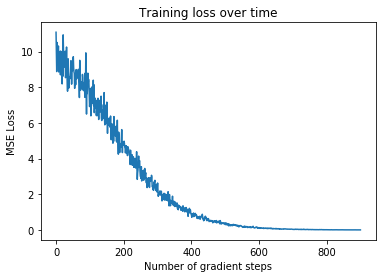

In [204]:
plt.title('Training loss over time')
plt.xlabel('Number of gradient steps')
plt.ylabel('MSE Loss')
plt.plot(training_losses)
plt.show()

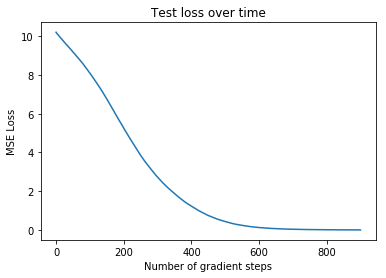

In [211]:
plt.title('Test loss over time')
plt.xlabel('Number of gradient steps')
plt.ylabel('MSE Loss')
plt.plot(test_losses)
plt.show()

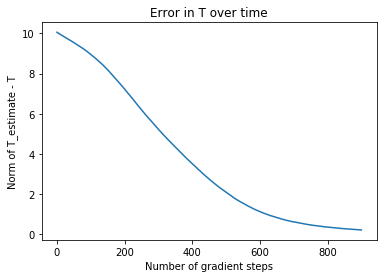

In [212]:
plt.title('Error in T over time')
plt.xlabel('Number of gradient steps')
plt.ylabel('Norm of T_estimate - T')
plt.plot(T_errors)
plt.show()

## MNIST

In [365]:
def train_network(net, num_epochs, trainloader, testloader):
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    loss = float('inf')
    training_losses = []
    test_losses = []
    epoch = 0

    while epoch < num_epochs:
        print(f"""
-------------------
Epoch {epoch}
-------------------""")
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.view((50, 784)).float()
            labels = torch.zeros(len(labels), 10).scatter_(1, labels.unsqueeze(1), 1.).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_losses.append(float(loss))

            if i % 100 == 0:
                print(f'Current training loss: {float(loss)}')
                test_loss = calculate_test_loss(net, criterion, testloader)
                test_losses.append(test_loss)
        epoch += 1
        
    return training_losses, test_losses

def calculate_test_loss(net, criterion, testloader):
    all_inputs = []
    all_labels = []
    for data in testloader:
        inputs, labels = data
        all_inputs.append(inputs)
        all_labels.append(labels)
            
    all_inputs = torch.cat(all_inputs)
    all_labels = torch.cat(all_labels)
    
    all_inputs = all_inputs.view((len(all_inputs), 784)).float()
    all_labels = torch.zeros(len(all_labels), 10).scatter_(1, all_labels.unsqueeze(1), 1.).float()
    
    all_outputs = net(all_inputs)
    loss = criterion(all_outputs, all_labels)
    return loss.float()

def plot_losses(losses, title):
    plt.title(title)
    plt.xlabel('Number of gradient steps')
    plt.ylabel('MSE Loss')
    plt.plot(losses)
    plt.show()

In [366]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden = nn.Linear(784, 1000)
        self.output = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

In [367]:
trainloader, testloader = get_loaders(50)
net = Network()

In [368]:
training_losses, test_losses = train_network(net, 2, trainloader, testloader)


    -------------------
    Epoch 0
    -------------------
Current training loss: 0.11194469779729843
Current training loss: 0.07196813821792603
Current training loss: 0.05627508461475372
Current training loss: 0.06339691579341888
Current training loss: 0.05714600160717964
Current training loss: 0.051428116858005524
Current training loss: 0.05026338994503021
Current training loss: 0.051901355385780334
Current training loss: 0.04771154746413231
Current training loss: 0.04665264114737511
Current training loss: 0.046843018382787704
Current training loss: 0.047079626470804214

    -------------------
    Epoch 1
    -------------------
Current training loss: 0.04736104607582092
Current training loss: 0.04296129196882248
Current training loss: 0.049099069088697433
Current training loss: 0.05236106365919113
Current training loss: 0.040156394243240356
Current training loss: 0.04363003373146057
Current training loss: 0.04338174685835838
Current training loss: 0.039582401514053345
Current tra

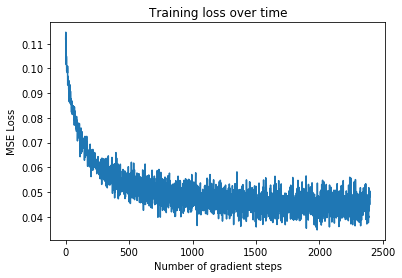

In [369]:
plot_losses(training_losses, 'Training loss over time')

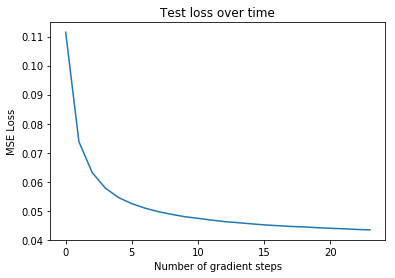

In [370]:
plot_losses(test_losses, 'Test loss over time')

## Feedback Alignment

In [371]:
class LinearFunctionFA(autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, weight_fa, bias=None):
        ctx.save_for_backward(input, weight, weight_fa, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, weight_fa, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_weight_fa = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight_fa)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_weight_fa, grad_bias

    
class LinearFA(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(LinearFA, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)
            
        self.weight_fa = torch.Tensor(output_features, input_features)
        
        # Not a very smart way to initialize weights
        self.weight.data.uniform_(-0.1, 0.1)
        self.weight_fa.data.uniform_(-0.1, 0.1)
        if bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)
            
    def forward(self, input):
        return LinearFunctionFA.apply(input, self.weight, self.weight_fa, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )


class NetworkFA(nn.Module):
    def __init__(self, layer_sizes):
        super(NetworkFA, self).__init__()
        input_size = 784
        output_size = 10
        self.layers = nn.ModuleList()
        self.backward_matrices = []
        for layer_size in layer_sizes:
            self.layers.append(LinearFA(input_size, layer_size))
            input_size = layer_size
        self.layers.append(LinearFA(input_size, output_size))
        # self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        

In [373]:
net_fa = NetworkFA([1000])

In [374]:
training_losses_fa, test_losses_fa = train_network(net_fa, 2, trainloader, testloader)


    -------------------
    Epoch 0
    -------------------
Current training loss: 1.0847026109695435
Current training loss: 0.20242880284786224
Current training loss: 0.15236762166023254
Current training loss: 0.1396704763174057
Current training loss: 0.1399211287498474
Current training loss: 0.0994403287768364
Current training loss: 0.12219938635826111
Current training loss: 0.09777261316776276
Current training loss: 0.1040581464767456
Current training loss: 0.0993775725364685
Current training loss: 0.09353389590978622
Current training loss: 0.10480168461799622

    -------------------
    Epoch 1
    -------------------
Current training loss: 0.08406037092208862
Current training loss: 0.08072341978549957
Current training loss: 0.08741261065006256
Current training loss: 0.06820905208587646
Current training loss: 0.0773511752486229
Current training loss: 0.07265724986791611
Current training loss: 0.07067744433879852
Current training loss: 0.06864539533853531
Current training loss: 0.

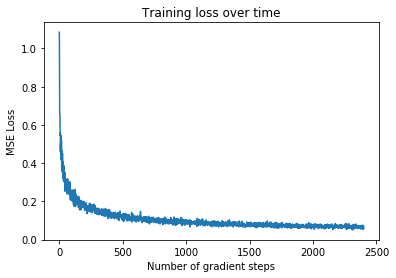

In [376]:
plot_losses(training_losses_fa, 'Training loss over time')

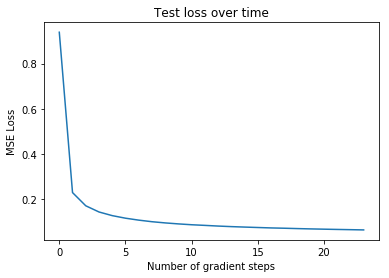

In [377]:
plot_losses(test_losses_fa, 'Test loss over time')

### Comparison of FA and regular backprop

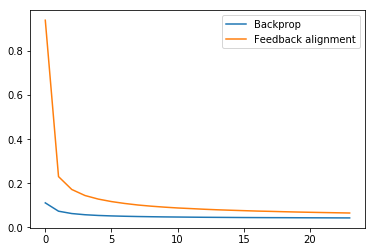

In [401]:
plt.plot(test_losses, label='Backprop')
plt.plot(test_losses_fa, label='Feedback alignment')
plt.legend()
plt.show()



## 4-Layer Non-Linear function approximation